In [ ]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn, optim, cuda, backends
from torch.autograd import Variable
from torch.utils import data
from torchvision import datasets, transforms, utils

In [ ]:
num_colors = 256
class DynamicBinarization():
    def __call__(self,x):
        return x.bernoulli()*2-1
def Binarize(x):
    return   x.bernoulli()*2-1
#transforms.RandomAffine(
#degrees = 10, translate=None, scale=(0.95,1.05), shear=(0.95,1.05,0.95,1.05), resample=1),
if num_colors == 1:
    trans = transforms.Compose([transforms.ToTensor(), DynamicBinarization()])
else:
    trans = transforms.ToTensor()

tr = data.DataLoader(datasets.MNIST('../data', train=True, download=True, transform=trans),
                     batch_size=128, shuffle=True, num_workers=1, pin_memory=True)
te = data.DataLoader(datasets.MNIST('../data', train=False, download=True, transform=trans),
                     batch_size=128, shuffle=True, num_workers=1, pin_memory=True)

In [ ]:
class MaskedConv2d(nn.Conv2d):
    
    def __init__(self, *args, mask_type='B', **kwargs):
        super(MaskedConv2d, self).__init__(*args, **kwargs)
        
        # Mask A) without center pixel
        # Mask B) with center pixel

        # 1 1 1 1 1
        # 1 1 1 1 1
        # 1 1 X 0 0
        # 0 0 0 0 0
        # 0 0 0 0 0

        self.mask = torch.ones_like(self.weight)
        _, _, height, width = self.weight.size()
        
        self.mask[:, :, height // 2, width // 2 + (1 if mask_type=='B' else 0):] = 0
        self.mask[:, :, height // 2 + 1:] = 0

        if cuda:
            self.mask = self.mask.cuda()
        
    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

class CroppedConv2d(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super(CroppedConv2d, self).__init__(*args, **kwargs)

    def forward(self, x):
        x = super(CroppedConv2d, self).forward(x)

        kernel_height, _ = self.kernel_size
        res = x[:, :, 1:-kernel_height, :]
        shifted_up_res = x[:, :, :-kernel_height-1, :]

        return res, shifted_up_res

class CausalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(CausalBlock, self).__init__()
        self.split_size = out_channels

        self.v_conv = CroppedConv2d(in_channels,
                                    2 * out_channels,
                                    (kernel_size // 2 + 1, kernel_size),
                                    padding=(kernel_size // 2 + 1, kernel_size // 2))
        self.v_fc = nn.Conv2d(in_channels,
                              2 * out_channels,
                              (1, 1))
        self.v_to_h = nn.Conv2d(2 * out_channels,
                                2 * out_channels,
                                (1, 1))

        self.h_conv = MaskedConv2d(in_channels,
                                   2 * out_channels,
                                   (1, kernel_size),
                                   padding=(0, kernel_size // 2),
                                   mask_type='A')
        self.h_fc = nn.Conv2d(out_channels,
                              out_channels,
                              (1, 1))

    def forward(self, image):
        v_out, v_shifted = self.v_conv(image)
        v_out += self.v_fc(image)
        v_out_tanh, v_out_sigmoid = torch.split(v_out, self.split_size, dim=1)
        v_out = torch.tanh(v_out_tanh) * torch.sigmoid(v_out_sigmoid)

        h_out = self.h_conv(image)
        v_shifted = self.v_to_h(v_shifted)
        h_out += v_shifted
        h_out_tanh, h_out_sigmoid = torch.split(h_out, self.split_size, dim=1)
        h_out = torch.tanh(h_out_tanh) * torch.sigmoid(h_out_sigmoid)
        h_out = self.h_fc(h_out)

        return v_out, h_out


class GatedBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(GatedBlock, self).__init__()
        self.split_size = out_channels

        self.v_conv = CroppedConv2d(in_channels,
                                    2 * out_channels,
                                    (kernel_size // 2 + 1, kernel_size),
                                    padding=(kernel_size // 2 + 1, kernel_size // 2))
        self.v_fc = nn.Conv2d(in_channels,
                              2 * out_channels,
                              (1, 1))
        self.v_to_h = nn.Conv2d(2 * out_channels,
                                2 * out_channels,
                                (1, 1))

        self.h_conv = MaskedConv2d(in_channels,
                                   2 * out_channels,
                                   (1, kernel_size),
                                   padding=(0, kernel_size // 2),
                                   mask_type='B')
        self.h_fc = nn.Conv2d(out_channels,
                              out_channels,
                              (1, 1))

        self.h_skip = nn.Conv2d(out_channels,
                                out_channels,
                                (1, 1))

        self.label_embedding = nn.Embedding(10, 2*out_channels)
        self.X_embedding = nn.Embedding(10, 28)
        self.Y_embedding = nn.Embedding(10, 28)

    def forward(self, x):
        v_in, h_in, skip, label = x[0], x[1], x[2], x[3]

        label_embedded = self.label_embedding(label).unsqueeze(2).unsqueeze(3)
        X_embedded = self.X_embedding(label).unsqueeze(1).unsqueeze(3)
        Y_embedded = self.Y_embedding(label).unsqueeze(1).unsqueeze(2)

        v_out, v_shifted = self.v_conv(v_in)
        v_out += self.v_fc(v_in)
        v_out += label_embedded
        v_out_tanh, v_out_sigmoid = torch.split(v_out, self.split_size, dim=1)
        v_out = torch.tanh(v_out_tanh) * torch.sigmoid(v_out_sigmoid)

        h_out = self.h_conv(h_in)
        v_shifted = self.v_to_h(v_shifted)
        h_out += v_shifted
        h_out += label_embedded
        h_out += X_embedded
        h_out += Y_embedded
        h_out_tanh, h_out_sigmoid = torch.split(h_out, self.split_size, dim=1)
        h_out = torch.tanh(h_out_tanh) * torch.sigmoid(h_out_sigmoid)

        # skip connection
        skip = skip + self.h_skip(h_out)

        h_out = self.h_fc(h_out)

        # residual connections
        h_out = h_out + h_in
        v_out = v_out + v_in

        return {0: v_out, 1: h_out, 2: skip, 3: label}


class GatedPixelCNN(nn.Module):
    def __init__(self, hidden_fmaps=64, causal_ksize=7, hidden_ksize=3, num_layers=12, out_hidden_fmaps=256, color_levels=1):
        super(GatedPixelCNN, self).__init__()

        DATA_CHANNELS = 1

        self.color_levels = color_levels
        self.hidden_fmaps = hidden_fmaps

        self.causal_conv = CausalBlock(DATA_CHANNELS,
                                       hidden_fmaps,
                                       causal_ksize)

        self.hidden_conv = nn.Sequential(
            *[GatedBlock(hidden_fmaps, hidden_fmaps, hidden_ksize) for _ in range(num_layers)]
        )

        self.label_embedding = nn.Embedding(10, self.hidden_fmaps)
        self.X_embedding = nn.Embedding(10, 28)
        self.Y_embedding = nn.Embedding(10, 28)

        self.out_hidden_conv = nn.Conv2d(hidden_fmaps,
                                         out_hidden_fmaps,
                                         (1, 1))

        self.out_conv = nn.Conv2d(out_hidden_fmaps,
                                  color_levels,
                                  (1, 1))

    def forward(self, image, label):
        count, data_channels, height, width = image.size()

        v, h = self.causal_conv(image)

        _, _, out, _ = self.hidden_conv({0: v,
                                         1: h,
                                         2: image.new_zeros((count, self.hidden_fmaps, height, width), requires_grad=True),
                                         3: label}).values()

        label_embedded = self.label_embedding(label).unsqueeze(2).unsqueeze(3)
        X_embedded = self.X_embedding(label).unsqueeze(1).unsqueeze(3)
        Y_embedded = self.Y_embedding(label).unsqueeze(1).unsqueeze(2)

        # add label bias
        out += label_embedded
        out += X_embedded
        out += Y_embedded
        out = F.relu(out)
        out = F.relu(self.out_hidden_conv(out))
        out = self.out_conv(out)

        out = out.view(count, self.color_levels, height, width)

        return out

def sample_images(net,num_colors=1,num_samples=8,label=None):
    sample = torch.Tensor(num_samples**2, 1, 28, 28).cuda()
    sample.fill_(0)
    if label is None:
        label = torch.randint(high=10, size=(num_samples**2,)).cuda()
    else:
        label = label*torch.ones((num_samples**2,)).cuda()
    with torch.no_grad():
        for i in range(28):
            for j in range(28):
                if num_colors == 1:
                    out = net(Variable(Binarize(sample)),label)
                    probs = torch.sigmoid(out[:, :, i, j]).data
                    sample[:, :, i, j] = torch.bernoulli(probs).cuda()
                else:
                    out = net(sample*2-1,label)
                    probs = torch.softmax(out[:, :, i, j],1).data
                    sample[:, :, i, j] = torch.multinomial(probs, 1).float()/(num_colors-1)
    return sample

def plot_half_boys(net,te,num_pics,num_colors):
  # Test of generating images from half an image
    with torch.no_grad():
        for input, label in te:
            label = Variable(label.cuda().long())[0:num_pics]
            input = Variable(input.cuda())
            target = Variable(input.data[:,0].unsqueeze(1))/2+1/2*torch.ones_like(input)
            input_plot = torch.Tensor(num_pics, 1, 28, 28).cuda()
            input_plot.fill_(0)
            input_plot[:,:,0:14,:]=target[0:num_pics,:,0:14,:]
            sample = torch.Tensor(num_pics, 1, 28, 28).cuda()
            sample.fill_(0)
            sample[:,:,0:14,:]=target[0:num_pics,:,0:14,:]
            for i in range(14,28):
                for j in range(28):
                    if num_colors == 1:
                        out = net(Variable(Binarize(sample)),label)
                        probs = torch.sigmoid(out[:, :, i, j]).data
                        sample[:, :, i, j] = torch.bernoulli(probs).cuda()
                    else:
                        out = net(sample*2-1,label)
                        probs = torch.softmax(out[:, :, i, j],1).data
                        sample[:, :, i, j] = torch.multinomial(probs, 1).float()/(num_colors-1)
 
            break
 
    plt.figure(figsize=(9,2*num_pics))
    for i in range(num_pics):
        plt.subplot(num_pics,3,1+3*i), plt.imshow(target.cpu().data.numpy()[i,0,:],cmap='gray')
        plt.ylabel(label[i].cpu().numpy())
        if i==0:
            plt.title('Groundtruth')
        plt.subplot(num_pics,3,2+3*i), plt.imshow(input_plot.cpu().data.numpy()[i,0,:],cmap='gray')
        if i==0:
            plt.title('Input to network')
        plt.subplot(num_pics,3,3+3*i), plt.imshow(sample.cpu().data.numpy()[i,0,:],cmap='gray')
        if i==0:
            plt.title('Prediction')
 
    plt.show()


In [ ]:
num_epochs = 50
num_samples = 6


net = GatedPixelCNN(hidden_fmaps=64,
                    causal_ksize=7, 
                    hidden_ksize=3, 
                    num_layers=12, 
                    out_hidden_fmaps=256, 
                    color_levels=num_colors)
net.cuda()
optimizer = optim.Adam(net.parameters(),lr=0.001)

if num_colors == 1:
    criterion = nn.BCEWithLogitsLoss(reduction='mean')
else:
    criterion = F.cross_entropy

sample = torch.Tensor(num_samples**2, 1, 28, 28).cuda()
epoch = 0

In [ ]:
train_plot_data = []
test_plot_data = []

start_event = torch.cuda.Event(enable_timing=True)
train_time = torch.cuda.Event(enable_timing=True)
test_time = torch.cuda.Event(enable_timing=True)
sample_time = torch.cuda.Event(enable_timing=True)
for _ in range(num_epochs):
    start_event.record()
    # train
    err_tr = []
    net.train(True)
    for input, label in tr:
        
        label = Variable(label.cuda().long())
        if num_colors == 1:
            input = Variable(input.cuda())
            target = Variable(input.data[:,0].unsqueeze(1))/2+1/2*torch.ones_like(input)
        else:
            target = Variable((input.data[:,0] * (num_colors-1)).long().cuda())
            input = Variable((input*2-1).cuda())
        loss = criterion(net(input, label), target)
        err_tr.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch += 1
    # compute error on test set
    err_te = []
    train_time.record()

    with torch.no_grad():
        for input, label in te:
            label = Variable(label.cuda().long())
            if num_colors == 1:
                input = Variable(input.cuda())
                target = Variable(input.data[:,0].unsqueeze(1))/2+1/2*torch.ones_like(input)
            else:
                target = Variable((input.data[:,0] * (num_colors-1)).long().cuda())
                input = Variable((input*2-1).cuda())
            loss = criterion(net(input, label), target)
            err_te.append(loss.item())
    test_time.record()
    # sample
    sample = sample_images(net,num_colors,num_samples)
    utils.save_image(sample, 'sample_{:02d}.png'.format(epoch), nrow=num_samples, padding=0)
    sample_time.record()

    train_plot_data.append(err_tr)
    test_plot_data.append(err_te)

    time_tr = start_event.elapsed_time(train_time)/1000
    time_te = start_event.elapsed_time(test_time)/1000-time_tr
    time_sa = start_event.elapsed_time(sample_time)/1000-time_tr-time_te
    print('epoch=%d; nll_tr=%.4f; nll_te=%.4f; time_tr=%.1fs; time_te=%.1fs, time_sa=%.1fs'
        % (epoch, np.mean(err_tr), np.mean(err_te), time_tr, time_te, time_sa))

train_plot_data = torch.tensor(train_plot_data)
torch.save(train_plot_data, 'train_plot_data.pt')
test_plot_data = torch.tensor(test_plot_data)
torch.save(test_plot_data, 'test_plot_data.pt')

epoch=32; nll_tr=0.5595; nll_te=0.5605; time_tr=171.1s; time_te=9.8s, time_sa=28.6s
epoch=33; nll_tr=0.5568; nll_te=0.5590; time_tr=171.3s; time_te=9.8s, time_sa=28.6s
epoch=34; nll_tr=0.5547; nll_te=0.5581; time_tr=171.1s; time_te=9.8s, time_sa=28.7s
epoch=35; nll_tr=0.5607; nll_te=0.5577; time_tr=171.2s; time_te=9.8s, time_sa=28.6s
epoch=36; nll_tr=0.5512; nll_te=0.5581; time_tr=171.2s; time_te=9.8s, time_sa=28.6s
epoch=37; nll_tr=0.5504; nll_te=0.5573; time_tr=171.2s; time_te=9.8s, time_sa=28.6s
epoch=38; nll_tr=0.5488; nll_te=0.5557; time_tr=171.2s; time_te=9.8s, time_sa=28.6s


In [ ]:
# Load trained network
net = GatedPixelCNN(hidden_fmaps=64,
                    causal_ksize=7, 
                    hidden_ksize=3, 
                    num_layers=12, 
                    out_hidden_fmaps=256, 
                    color_levels=num_colors)
net.cuda()

checkpoint = torch.load("Gated_PixelCNN_e20c001.pth")
net.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
torch.save(net.state_dict(), 'Spacial_Gated_PixelCNN_e{:02d}c{:03d}.pth'.format(epoch,num_colors))

In [ ]:
sample = sample_images(net, num_colors, num_samples)
utils.save_image(sample, 'sample_label.png', nrow=num_samples, padding=0)

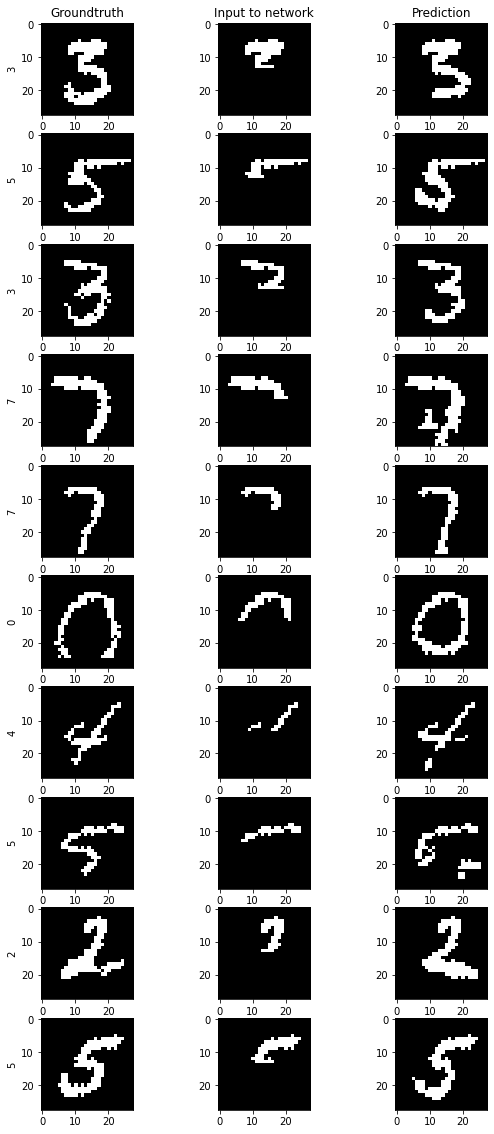

In [ ]:
plot_half_boys(net,te,10,num_colors)